In [2054]:
import numpy as np 
import pandas as pd 
import sys
sys.setrecursionlimit(1500)

In [2055]:
students = pd.read_csv("students.csv")
exams = pd.read_csv("exams.csv")
enrolments = pd.read_csv("enrolements.csv")
rooms = pd.read_csv("rooms.csv")
slots= pd.read_csv("slots.csv")

In [2056]:
class Exam:
    def __init__(self, exam_code, name, duration, department_code):
        self.code = exam_code
        self.name = name
        self.duration = duration
        self.duration_min = 0
        self.dep_code = department_code
        self.conflicts = 0
        self.examConflicts = set()
        self.priority = 0
        self.slot = -1
        self.student_codes = []
        self.students = []
        self.room = -1
        self.roomAssigned = False

class Student:
    def __init__(self, student_code, course_code):
        self.code = student_code
        self.course_code = course_code
        self.exams = []
        self.exam_codes = []

class Enrolment:
    def __init__(self, student_code, exam_code):
        self.student_code = student_code
        self.exam_code = exam_code

class Room:
    def __init__(self, room_code, capacity):
        self.code = room_code
        self.capacity = capacity
        self.status = False
class Slot:
    def __init__(self, index, date, day, type):
        self.index = index
        self.date = date
        self.day = day
        self.type = type
        self.exams = []
class RoomSlotMap:
    def __init__(self, slot, room):
        self.slot = slot
        self.room = room

In [2057]:
examObjects = [Exam(**kwargs) for kwargs in exams.to_dict(orient='records')]

studentObjects = [Student(**kwargs) for kwargs in students.to_dict(orient='records')]

enrolmentObjects = [Enrolment(**kwargs) for kwargs in enrolments.to_dict(orient='records')]

roomObjects = [Room(**kwargs) for kwargs in rooms.to_dict(orient='records')]

slotObjects = [Slot(**kwargs) for kwargs in slots.to_dict(orient='records')]

In [2058]:
for i in enrolmentObjects:
    for j in studentObjects:
        if j.code == i.student_code:
            j.exam_codes.append(i.exam_code)

In [2059]:
for i in studentObjects:
    for j in examObjects:
        for k in i.exam_codes:
            if k == j.code:
                i.exams.append(j)

In [2060]:
for i in enrolmentObjects:
    for j in examObjects:
        if j.code == i.exam_code:
            j.student_codes.append(i.student_code)

In [2061]:
for i in examObjects:
    for j in studentObjects:
        for k in i.student_codes:
            if k == j.code:
                i.students.append(j)

In [2062]:
studArr = []
for i in examObjects:
        studArr.append([i.code, len(i.student_codes), len(i.students)])

In [2063]:
pd.DataFrame(studArr).to_csv('test_log.csv')

In [2064]:
def getRoomKey(obj):
    return obj.capacity

In [2065]:
roomSlotArr = []
for i in slotObjects:
    for j in sorted(roomObjects, key=getRoomKey):
        roomSlotArr.append([i, j])

In [2066]:
roomSlotArrDF = pd.DataFrame(roomSlotArr, columns = ["slot", "room"])
roomSlotMapObjects = [RoomSlotMap(**kwargs) for kwargs in roomSlotArrDF.to_dict(orient='records')]
len(roomSlotMapObjects)

918

In [2067]:
def hhToSeconds(s):
    t = 0
    splitTime = s.split(':')
    t = 60 * int(splitTime[0]) + int(splitTime[1])
    return t

In [2068]:
for i in examObjects:
    i.duration_min = hhToSeconds(str(i.duration))

In [2069]:
def degreeOfConflict(exam):
    s = set()
    for i in exam.students:
        for j in i.exams:
            if exam.code != j.code:
                s.add(j)
    exam.examConflicts = s
    return len(s)

In [2070]:
def degreeOfConflict_old(exam):
    flagExam = enrolmentObjects[0]
    degree = 0
    for i in enrolmentObjects:
        if i.exam_code == exam.code:
            flagExam = i
            
    for j in enrolmentObjects:
        if j.exam_code != flagExam.exam_code and j.student_code == flagExam.student_code:
            degree += 1
    return degree

In [2071]:
for i in examObjects:
    i.conflicts = degreeOfConflict(i)

In [2072]:
def partialExamOrdering():
    sup = np.zeros(len(examObjects))
    for i in range(len(examObjects)):
        for j in range(len(examObjects)):
            if examObjects[i].conflicts > examObjects[j].conflicts:
                sup[i] = sup[i] + 1
                continue
            elif examObjects[i].conflicts < examObjects[j].conflicts:
                sup[j] = sup[j] + 1
                continue
            if len(examObjects[i].students) > len(examObjects[j].students):
                sup[i] = sup[i] + 1
                continue
            elif len(examObjects[i].students) < len(examObjects[j].students):
                sup[j] = sup[j] + 1
                continue
            if examObjects[i].duration_min > examObjects[j].duration_min:
                sup[i] = sup[i] + 1
                continue
            elif examObjects[i].duration_min < examObjects[j].duration_min:
                sup[j] = sup[j] + 1
                continue
            if examObjects[i].code > examObjects[j].code:
                sup[j] = sup[j] + 1
                continue
            elif examObjects[i].code < examObjects[j].code:
                sup[i] = sup[i] + 1
                continue
    return sup                               

In [2073]:
def totalConflictsForExams():
    partialExamOrder = partialExamOrdering()
    for i in range(len(examObjects)):
        examObjects[i].priority = partialExamOrder[i]  

In [2074]:
def getKey(obj):
    return obj.priority

In [2075]:
EVAPORATION_RATE = 0.2
numAnts = 3
t_max = 5.0
t_min = 0.0019
MAX_ITER = 2
alpha = 1.0
beta = 2.0

In [2076]:
pheromoneMatrix = []

def updatePheromoneMatrix():
    for i in range(len(examObjects)):
        for j in range(len(slotObjects)):
            if examObjects[i].slot.index == slotObjects[j].index:
                pheromoneMatrix[i][j] = (1 - EVAPORATION_RATE) * pheromoneMatrix[i][j] + 1
            else:
                pheromoneMatrix[i][j] = (1 - EVAPORATION_RATE) * pheromoneMatrix[i][j]
            if pheromoneMatrix[i][j] < t_min:
                pheromoneMatrix[i][j] = t_min
            elif pheromoneMatrix[i][j] > t_max:
                pheromoneMatrix[i][j] = t_max
    
def initPheromoneMatrix(exams, slots, value):
        for i in range(exams.size):
            pheromoneMatrix.append([value for j in range(len(slots))])
    

In [2077]:
heuristicsMatrix = []

def initHeuristicsMatrix(exams, slots):
    for i in range(0, len(exams)):
        heuristicsMatrix.append([1 for j in range(len(slots))])

The room assignment is done on a daily
basis; firstly, all the timeslots for Monday are considered then the ones for Tuesday
until assignments are made for all timeslots of each day

1. All rooms are declared idle by setting ‗usage status‘ for each one to zero
2. For each timeslot on the day, do the following:
a) Select the next event yet to be assigned a room based on two criteria
b) (i) if suitable rooms (rooms with capacities that can hold the number of
students to participate in the event) exist for the event, assign the event
the room with the least capacity among the suitable rooms (ii) otherwise
try to move the event to another timeslot and restart the process, if no
64
feasible timeslot can be found for the event then stop the search and
declare the solution to be infeasible. (iii) Proceed to 2(c) if condition
b(i) is true.
c) Update the usage status of the room assigned to the event in b(i) by the
number of timeslots the event placed in it will occupy preventing it
from being assigned to another event while being busy.
d) If events remain in the timeslot not yet assigned a room then go back to
2(a).
3. Move to another day

In [2078]:
def assignRooms(sortedExams):
    for i in sortedExams:
        for j in roomSlotMapObjects:
                if len(i.students) < j.room.capacity and j.room.status == False:
                    print(i.code + " : " + j.room.code + " : " + str(j.room.capacity) + " : " + str(j.slot.index)+ " : " + str(j.slot.day))
                    i.room = j
                    i.roomAssigned = True
                    j.room.status = True
                 
                

In [2079]:
def checkForHardConstraintViolations(exam, slot):
    score = 0
    for i in exam.students:
        for j in i.exams:
            if j.code != exam.code and j.slot != -1:
                if j.slot.index == slot.index:
                    score += 4
                if j.slot.index == 12:
                    score += 4
            if slot.index % 3 == 0 and exam.duration_min > 90:
                score += 4
    return score
                    

In [2080]:
def checkForSoftConstraintViolations(exam, slot):
    score = 0
    for i in exam.students:
        for j in i.exams:
            if j.code != exam.code and j.slot != -1:
                if np.abs(j.slot.index - slot.index) < 4:
                    score += 1
    return score

In [2081]:
def findForbiddenSlots(exam):
    forbiddenSlots = set()
    forbiddenSlots.add(slotObjects[11])
    for i in exam.examConflicts:
        if i.slot != -1 and i.code != exam.code:
            forbiddenSlots.add(i.slot)
    return forbiddenSlots

In [2082]:
def numAdditionalViolations(exam, slot):
    score = 0
    score += checkForHardConstraintViolations(exam, slot)
    score += checkForSoftConstraintViolations(exam, slot)
    return score

In [2083]:
def pheroHeuristicSummation(examIndex, slotIndex):
    sum = 0
    for j in range(len(slotObjects)):
        if j != slotIndex:
            sum = (pheromoneMatrix[examIndex][j]**alpha) * (heuristicsMatrix[examIndex][j]**beta)
    return sum

In [2084]:
forbiddenSlots = list(findForbiddenSlots(examObjects[10]))
forbiddenSlots

In [2085]:
def chooseSlot(examIndex, exam, slots):
    desirability = np.zeros(len(slotObjects))
    forbiddenSlots = list(findForbiddenSlots(exam))
    for i in range(len(slotObjects)):
        for j in forbiddenSlots:
            if slotObjects[i].index == j.index:
                #print("Desirability for " + str(slotObjects[i].index) + " is -1")
                desirability[i] = -1
                continue
            heuristicsMatrix[examIndex][i] = 1 / (1 + numAdditionalViolations(exam, slotObjects[i]))
            desirability[i] = ((pheromoneMatrix[examIndex][i]**alpha) * (heuristicsMatrix[examIndex][i]**beta))/pheroHeuristicSummation(examIndex, i)
    #print(exam.code + ": " + ": " + str(slotObjects[np.argmax(desirability)].index))
    maxProb = np.argmax(desirability)
    #print(str(maxProb))
    desirableSlots = []
    for i in range(len(desirability)):
        if desirability[maxProb] == desirability[i]:
            desirableSlots.append(slotObjects[i])
    #print(str(desirableSlots))
    rand = np.random.randint(0, len(desirableSlots))
    return desirableSlots[rand]

In [2086]:
def evaluateHardConstraints_old():
    countHard = 0
    for i in studentObjects:
        for j in i.exams:
            if j.slot == -1:
                countHard += 1
            else:
                for k in i.exams:
                    if j.code != k.code and j.slot.index == k.slot.index:
                        countHard += 1
                if j.slot.index == 12:
                    countHard += 1
                if j.slot.index % 3 == 0 and j.duration_min > 90:
                    countHard += 1
    return countHard
                    

In [ ]:
def evaluateHardConstraints():
    countHard = 0
    for i in examObjects:
        for j in i.examConflicts:
            if i.slot.index == j.slot.index:
                countHard += 1
        if i.slot.index == 12:
            countHard += 1
        if i.slot.index % 3 == 0 and i.duration_min > 90:
            countHard += 1
    return countHard

In [2087]:
def evaluateSoftConstraints():
    countSoft = 0
    for i in examObjects:
        for j in i.examConflicts:
            if np.abs(i.slot.index - j.slot.index) < 4:
                countSoft += 1
    return countSoft

In [ ]:
def evaluateSoftConstraints_old():
    countSoft = 0
    for i in studentObjects:
        for j in i.exams:
            for k in i.exams:
                if j.code != k.code and np.abs(j.slot.index - k.slot.index) < 4:
                    countSoft += 1
    return countSoft

In [2088]:
def evaluate():
    metricHardConstraints = 0
    metricSoftConstraints = 0
    metricHardConstraints += evaluateHardConstraints()
    metricSoftConstraints += evaluateSoftConstraints()
    return metricSoftConstraints, metricHardConstraints

1: move an event from a timeslot to another timeslot

2: swap the timeslots of two events


The second local search routine LS2(); which is derived from LS1() is applied only
after a feasible solution has been found, in fact it is applied to the iteration-best
solution Aib to remove events from tightly packed timeslots and place them in ‗idle‘
ones so as to make it easy to assign rooms to events in Aib. If any event exists that
cannot be assigned a room due to the fact that all suitable rooms of that event have
been assigned to other events in the same timeslot then it is moved to another timeslot
by LS2() and the room assignment is restarted. LS2() implements only the
neighbourhood move N1 in LS1() and its failure to find a new feasible timeslot for an
event which cannot be assigned a room in its current timeslot triggers the end of room
assignment and the solution is considered infeasible.


In [2089]:
def findAnotherSlot(exam, conflictingExams, forbiddenSlot):
    slot = forbiddenSlot
    for i in slotObjects:
        for j in conflictingExams:
            if i.index == j.slot.index:
                continue
            if np.abs(i.index - j.slot.index) < 2:
                continue
            if i.index == 12:
                continue
            if i.index % 3 == 0 and exam.duration_min > 90:
                continue
            if i.index != forbiddenSlot.index:
                slot = i
    return slot


In [2090]:
def localSearchToEaseHardConstraints(solution):
    L = set()
    for i in range(len(solution)):
        exam = list(list(solution)[i])[0]
        slot = list(list(solution)[i])[1]
        flag = False
        #print("Testing: " + exam.code + "currently at slot: " + str(slot.index) + " : " +slot.day + " : " + str(exam.duration_min))
        if exam.slot.index % 3 == 0 and exam.duration_min > 90:
            flag = True
        if exam.slot.index == 12:
            flag = True
        for j in exam.examConflicts:
            if j.slot.index == slot.index:
                #print(exam.code + " conflicts with " + j.code + "at " + str(j.slot.index))
                flag = True
            if np.abs(j.slot.index - slot.index) < 2:
                #print(exam.code + " conflicts with " + j.code + "at " + str(j.slot.index))
                flag = True
        if flag == True:
            #print("Find another slot for: " + exam.code + "currently at slot: " + str(slot.index) + " : " +slot.day)
            slot = chooseSlot(i, exam, slotObjects)
            #slot = findAnotherSlot(exam, exam.examConflicts, slot)
            #print("Found another slot for: " + exam.code + "at slot: " + str(slot.index) + " : " +slot.day)
            L.add((exam, slot))
        else:
            #print("No slot needed for: " + exam.code + "at slot: " + str(slot.index) + " : " +slot.day)
            L.add((exam, slot))
    return L

In [2091]:
def roomAssignment(exam, slot):
    flag = False
    for k in roomSlotMapObjects:
            if slot.index == k.slot.index and len(exam.students) < k.room.capacity:
                for l in examObjects:
                    if l.room != -1:
                        if l.room.code != k.room.code:
                            print(exam.code + " : " + str(slot.index) + " : " + slot.day + " : " + k.room.code + " : " + str(len(exam.students)) + ": " + str(k.room.capacity))
                            exam.room = k.room
                            flag = False
                        else:
                            flag = True
    return flag

In [2092]:

def localSearchToEaseSoftConstraints(solution):
    L = set()
    for i in solution:
        exam = list(i)[0]
        slot = list(i)[1]
        flag = False
        
        for j in exam.examConflicts:
            if np.abs(j.slot.index - slot.index) < 4:
                flag = True
        if flag == True:
            slot = findAnotherSlot(exam, exam.examConflicts, slot)
            L.add((exam, slot))
        else:
            L.add((exam, slot))
        roomAssigmentFlag = roomAssignment(exam, slot)
        if roomAssigmentFlag:
            L = localSearchToEaseSoftConstraints(L)
    
    return L

In [2093]:
def assignSlotsForSolution(solution):
    for i in solution:
        if list(i)[1] == 0:
            print(i)
        list(i)[0].slot = list(i)[1]

In [2094]:
index = 0
initPheromoneMatrix(exams, slotObjects, t_max)
initHeuristicsMatrix(exams, slotObjects)
totalConflictsForExams()
sortedExamsByPriority = sorted(examObjects, key=getKey, reverse=True)
evaluationSoftMap = []
evaluationHardMap = []
A_gb = set()
prevScore = 0
while index < MAX_ITER:
    A_ib = set()
    prevScoreAnt = 0
    for k in range(numAnts):
        A = set()
        chosenSlot = 0
        for i in range(len(examObjects)):
            chosenSlot = chooseSlot(i,sortedExamsByPriority[i], slotObjects)
            A.add((sortedExamsByPriority[i], chosenSlot))
        assignSlotsForSolution(A)
        #print("----LOCAL SEARCH TO EASE HARD CONSTRAINTS FOR ANT: " + str(k) + "------")
        Al = localSearchToEaseHardConstraints(A)
        assignSlotsForSolution(Al)
        scoreAl = evaluate()[0] + evaluate()[1]
        #print("--Al with score: " + str(scoreAl))
        if A_ib != set():
            A_ib = Al if scoreAl < prevScoreAnt else A_ib
            prevScoreAnt = scoreAl if scoreAl < prevScoreAnt else prevScoreAnt
        else:
            A_ib = Al
            prevScoreAnt = scoreAl
        #print("--A_ib with score: " + str(prevScoreAnt))
    assignSlotsForSolution(A_ib)
    #print("------LOCAL SEARCH TO EASE SOFT CONSTRAINTS FOR ITERATION: " + str(index) + "--------")
    A_ibl = localSearchToEaseSoftConstraints(A_ib)
    assignSlotsForSolution(A_ibl)
    scoreA_ibl = evaluate()[0] + evaluate()[1]
    #print("--A_ibl with score: " + str(scoreA_ibl))
    if A_gb != set():
        A_gb = A_ibl if scoreA_ibl < prevScore else A_gb
        prevScore = scoreA_ibl if scoreA_ibl < prevScore else prevScore
    else:
        A_gb = A_ibl
        prevScore = scoreA_ibl
    #print("--A_gb with score: " + str(prevScore))
    assignSlotsForSolution(A_gb)
    #assignRooms(sortedExamsByPriority)
    updatePheromoneMatrix()
    evaluationSoftMap.append((index, evaluate()[0]))
    evaluationHardMap.append((index, evaluate()[1]))
    #print("Iteration :" + str(index) + " complete.")
    index += 1

<AxesSubplot:xlabel='Iterations'>

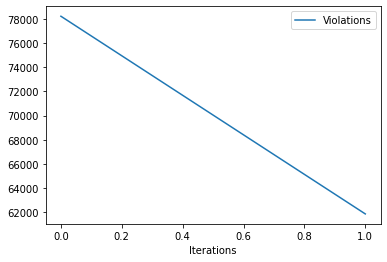

In [2095]:
evalHardDF = pd.DataFrame(evaluationHardMap, columns=['Iterations', 'Violations'])
evalHardDF.plot.line(x='Iterations', y='Violations')

<AxesSubplot:xlabel='Iterations'>

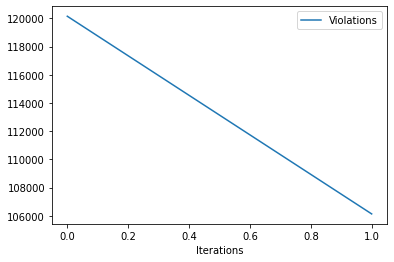

In [2096]:
evalSoftDF = pd.DataFrame(evaluationSoftMap, columns=['Iterations', 'Violations'])
evalSoftDF.plot.line(x='Iterations', y='Violations')

In [2097]:
studentArr = []
for i in studentObjects:
    for j in i.exams:
        studentArr.append([i.code, j.code, j.slot.index, j.slot.day, j.slot.type, j.duration, len(j.students)])

In [2098]:
pd.DataFrame(studentArr).to_csv('student_output.csv')